# Trabajo Práctico 1

### Imports generales y librerias

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

## Ejercicio 4

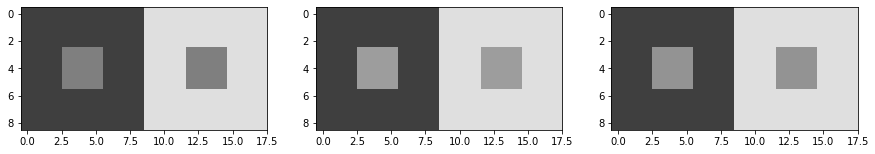

In [2]:
# Definimos el tamaño del los bloques del fondo, seguido armamos el fondo
OUTER_BLOCK_SIZE = 9

background_left = np.full((OUTER_BLOCK_SIZE, OUTER_BLOCK_SIZE), 63, dtype=np.uint8)
background_right = np.full((OUTER_BLOCK_SIZE, OUTER_BLOCK_SIZE), 223, dtype=np.uint8)
total_background = cv2.hconcat([background_left, background_right])

# Dibujamos inicialmente el cuadrado
cv2.rectangle(total_background, (3, 3), (5, 5), 127, thickness=-1)
cv2.rectangle(total_background, (12, 3), (14, 5), 127, thickness=-1)

figure, axes = plt.subplots(ncols=3, figsize=(15,15))
axes[0].imshow(total_background, cmap="gray", vmin=0, vmax=255)

cv2.rectangle(total_background, (3, 3), (5, 5), 157, thickness=-1)
cv2.rectangle(total_background, (12, 3), (14, 5), 157, thickness=-1)

axes[1].imshow(total_background, cmap="gray", vmin=0, vmax=255)

cv2.rectangle(total_background, (3, 3), (5, 5), 147, thickness=-1)
cv2.rectangle(total_background, (12, 3), (14, 5), 147, thickness=-1)

axes[2].imshow(total_background, cmap="gray", vmin=0, vmax=255)


Podemos observar que al colocar los bloques en un rango de 147 a 157 parecen mas iguales, aunque efectivamente lo son, hasta en el primer caso

## Ejercicio 5

Cargamos la imagen con la que trabajaremos en este ejercicio: mono.bmp

In [3]:
!wget https://raw.githubusercontent.com/newtonis/tps_imagenes/master/tp1/mono.bmp

--2020-08-22 03:57:02--  https://raw.githubusercontent.com/newtonis/tps_imagenes/master/tp1/mono.bmp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66614 (65K) [image/bmp]
Saving to: ‘mono.bmp.1’

mono.bmp.1          100%[===================>]  65.05K  --.-KB/s    in 0.03s   

2020-08-22 03:57:02 (2.35 MB/s) - ‘mono.bmp.1’ saved [66614/66614]



Veamos que contiene la imagen por arriba. Podemos observar que tiene para cada pixel un valor de 0 a 255 indicando la intensidad de gris siendo 0 negro y 255 blanco.

In [4]:
img = cv2.imread("mono.bmp", cv2.IMREAD_GRAYSCALE)
img

array([[227,  57,  87, ...,  90, 116, 128],
       [114,  83,  71, ..., 117,  86,  64],
       [ 77, 112,  78, ..., 102,  66, 139],
       ...,
       [102, 135, 143, ...,  95,  96,  88],
       [138, 140, 124, ...,  90,  87,  83],
       [ 82,  68,  57, ...,  41,  41,  37]], dtype=uint8)

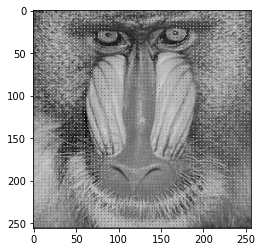

In [5]:
plt.imshow(img, cmap="gray", vmin=0, vmax=255)

### Observaremos los resultados de decimar la imagen de distintas maneras

Decimaremos la imagen quedandonos con el pixel de la posición (2, 2) para cada grupode 4 pixeles que tomemos

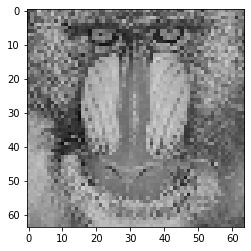

In [6]:
downsampled_monkey = img[1::4,1::4]
plt.imshow(downsampled_monkey, cmap="gray", vmin=0, vmax=255)

Si ahora repetimos la decimación con el pixel de la posición (1, 1)....

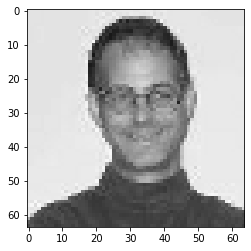

In [7]:
downsampled_dani = img[0::4,0::4]
plt.imshow(downsampled_dani, cmap="gray", vmin=0, vmax=255)

Realizamos ahora la decimación tomando el promedio de los 4 puntos

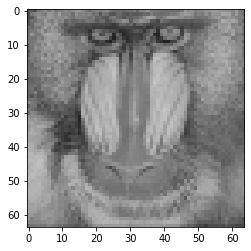

In [8]:
aux_list = list(range(0, len(img), 4))
prom_monkey = np.array([np.mean(img[i:i+4, j:j+4]) for i in aux_list for j in aux_list])
prom_monkey.resize((len(img) // 4, len(img[0]) // 4))
plt.imshow(prom_monkey, cmap="gray", vmin=0, vmax=255)

## Interpolaciones

Habiendo realizado estas decimaciones, en esta sección nos detendremos a ver como podemos realizar un up-sample tomando una interpolación bilineal así como una bicubica de las 3 imagenes. Dado los fines académicos, comenzaremos por realizar los algoritmos de interpolación.

Comenzaremos con una función que nos permita realizar la interpolación bilinear

In [9]:
def resize_bilinear_interpol(img, scale):
    new_img = np.zeros((img.shape[0] * scale, img.shape[1] * scale), dtype=np.uint8)
    new_img[::scale, ::scale] = img[::]

    def inter_pol_1D(X, X1, X2, val_X1_cte, val_X2_cte):
        return (abs(X2 - X) / abs(X2 - X1)) * val_X1_cte + (abs(X - X1) / abs(X2 - X1)) * val_X2_cte

    for x in range(new_img.shape[0]):
        for y in range(new_img.shape[1]):
            y1 = y // scale
            y2 = (y + scale) // scale
            x1 = x // scale
            x2 = (x + scale) // scale
            if(x2 not in range(img.shape[0]) and y2 not in range(img.shape[0])):
                new_img[x, y] = inter_pol_1D(y, y1 * scale, y2 * scale,
                    inter_pol_1D(x, x1 * scale, x2 * scale, img[x1, y1], img[x1, y1]),
                    inter_pol_1D(x, x1 * scale, x2 * scale, img[x1, y1], img[x1, y1])
                    )
            elif(x2 not in range(img.shape[0])):
                new_img[x, y] = inter_pol_1D(y, y1 * scale, y2 * scale,
                    inter_pol_1D(x, x1 * scale, x2 * scale, img[x1, y1], img[x1, y1]),
                    inter_pol_1D(x, x1 * scale, x2 * scale, img[x1, y2], img[x1, y2])
                    )
            elif(y2 not in range(img.shape[0])):
                new_img[x, y] = inter_pol_1D(y, y1 * scale, y2 * scale,
                    inter_pol_1D(x, x1 * scale, x2 * scale, img[x1, y1], img[x2, y1]),
                    inter_pol_1D(x, x1 * scale, x2 * scale, img[x1, y1], img[x2, y1])
                    )
            else:
                new_img[x, y] = inter_pol_1D(y, y1 * scale, y2 * scale,
                    inter_pol_1D(x, x1 * scale, x2 * scale, img[x1, y1], img[x2, y1]),
                    inter_pol_1D(x, x1 * scale, x2 * scale, img[x1, y2], img[x2, y2])
                    )

    return new_img

Ahora observemos los resultados sobre las 3 imagenes anteriores

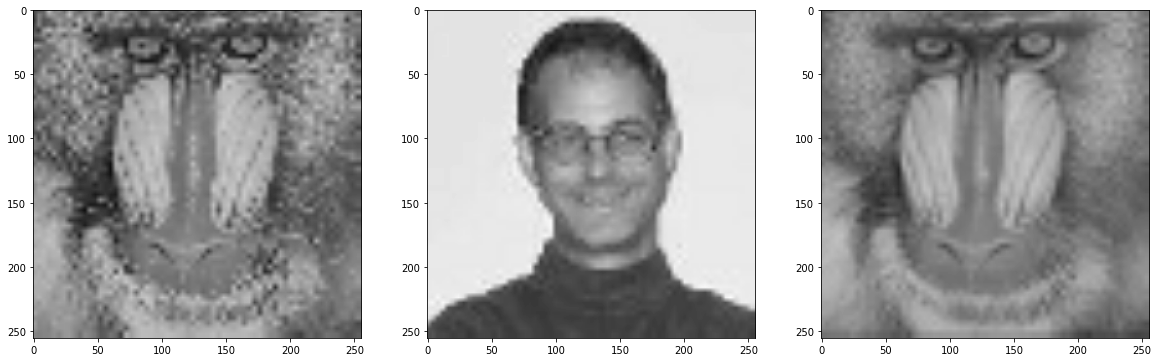

In [10]:
figure, axes = plt.subplots(ncols=3, figsize=(20, 20))
up_sampled_monkey = resize_bilinear_interpol(img[1::4, 1::4], 4)
up_sampled_dani = resize_bilinear_interpol(img[0::4, 0::4], 4)
up_sampled_prom = resize_bilinear_interpol(prom_monkey, 4)

axes[0].imshow(up_sampled_monkey, cmap="gray", vmin=0, vmax=255)
axes[1].imshow(up_sampled_dani, cmap="gray", vmin=0, vmax=255)
axes[2].imshow(up_sampled_prom, cmap="gray", vmin=0, vmax=255)

A modo de ver como funciona nuestro algoritmo observemos una de estas fotos con interpolación lineal de opencv

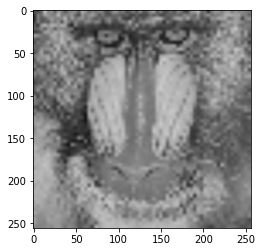

In [11]:
img_bilinear_cv2 = cv2.resize(img[1::4, 1::4], (256, 256), cv2.INTER_LINEAR)
plt.imshow(img_bilinear_cv2, cmap="gray", vmin=0, vmax=255)

Pareceria estar andando aceptablemente bien.

Ahora continuaremos con un algoritmo para realizar la inteprolacion bicúbica.

Las siguientes variables y funciones nos serán de utilidad

In [12]:
pre_matrix = np.array([
    [1, 0, 0, 0],
    [0, 0, 1, 0],
    [-3, 3, -2, -1],
    [2, -2, 1, 1]
])
post_matrix = np.array([
    [1, 0, -3, 2],
    [0, 0, 3, -2],
    [0, 1, -2, 1],
    [0, 0, -1, 1]
])

def fx_(vec, X, Y):
    b = vec[X - 1][Y] if X > 0  else 0
    a = vec[X + 1][Y] if X < vec.shape[0] - 1 else 0
    return (a - b) / 2

def fy_(vec, X, Y):
    b = vec[X][Y - 1] if Y > 0  else 0
    a = vec[X][Y + 1] if Y < vec.shape[1] - 1 else 0

    return (a - b) / 2

def fxy_(vec, X, Y):
    a = vec[X - 1][Y - 1] if X > 0 and Y > 0  else 0 
    b = vec[X + 1][Y + 1] if X < vec.shape[1] - 1 and Y < vec.shape[1] - 1 else 0 
    c = vec[X + 1][Y - 1] if X < vec.shape[1] - 1 and Y > 0 else 0 
    d = vec[X - 1][Y + 1] if X > 0 and Y < vec.shape[1]-1 else 0 
    return (a + b - c - d) / 4

def get_derivatives(img, m, n):
    fx = np.zeros((m + 1, n + 1))
    fy = np.zeros((m + 1, n + 1))
    fxy = np.zeros((m + 1, n + 1))
    for i in range(m):
        for j in range(n):
            fx[i][j] = fx_(img, i, j)
            fy[i][j] = fy_(img, i, j)
            fxy[i][j] = fxy_(img, i, j)
    return fx, fy, fxy

def get_f_matrix(f, fx, fy, fxy, x, y):
    f_mat = np.array([
                [f[x, y], f[x, y + 1], fy[x, y], fy[x, y + 1]],
                [f[x + 1, y] , f[x + 1, y + 1], fy[x + 1, y], fy[x + 1, y + 1]],
                [fx[x, y], fx[x, y + 1], fxy[x, y], fxy[x, y + 1] ],
                [fx[x + 1, y], fx[x + 1, y + 1], fxy[x + 1, y], fxy[x + 1, y + 1]]
                    ])
    return f_mat

In [13]:
def resize_bicubic_interpol(img, scale):
    img = img.astype(np.float64)
    m, n = img.shape
    new_img = np.zeros((scale * m, scale * n))
    new_img = new_img.astype(np.float64)
    img = np.pad(img, 1, 'edge')

    fx, fy, fxy = get_derivatives(img, m, n)

    for i in range(m):
        for j in range(n):
            x, y = i, j
            alpha_vector = np.matmul(np.matmul(pre_matrix, get_f_matrix(img, fx, fy, fxy, x, y)), post_matrix)
            for k in range(scale):
                for l in range(scale):
                    x_ = k / scale
                    y_ = l / scale

                    cubic_x = np.array([1, x_, x_**2, x_**3])
                    cubic_y = np.array([1, y_, y_**2, y_**3])

                    new_img[x * scale + k, y * scale + l] = min(np.matmul(np.matmul(cubic_x, alpha_vector), cubic_y.T), 255)

    return new_img

Con nuestra función de interpolación bicúbica, realizaremos ahora el up-sampling

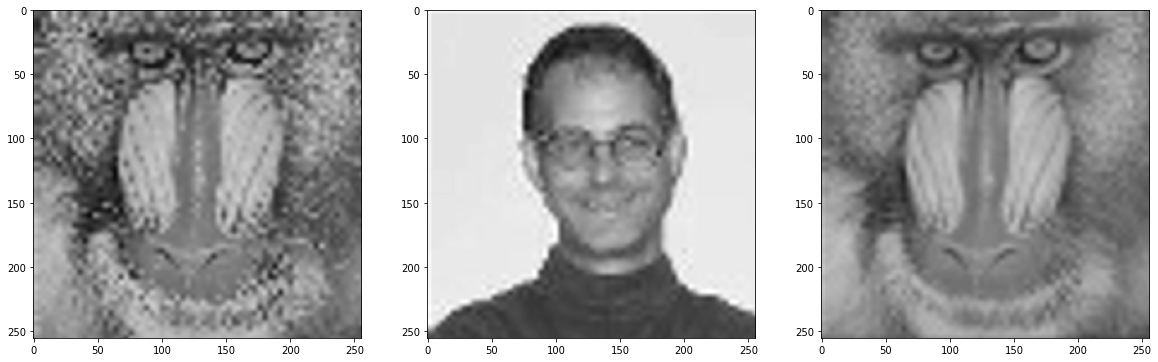

In [14]:
figure, axes = plt.subplots(ncols=3, figsize=(20, 20))
up_sampled_monkey = resize_bicubic_interpol(img[1::4, 1::4], 4)
up_sampled_dani = resize_bicubic_interpol(img[0::4, 0::4], 4)
up_sampled_prom = resize_bicubic_interpol(prom_monkey, 4)

axes[0].imshow(up_sampled_monkey, cmap="gray", vmin=0, vmax=255)
axes[1].imshow(up_sampled_dani, cmap="gray", vmin=0, vmax=255)
axes[2].imshow(up_sampled_prom, cmap="gray", vmin=0, vmax=255)

Nuevamente observermos como open cv maneja esta interpolación para entender que tan bien funciona nuestro algoritmo.

(256, 256) (256, 256)


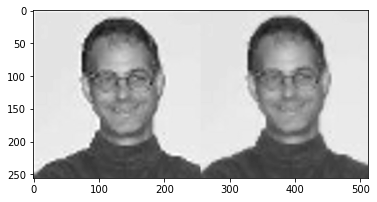

In [15]:
img_bicubica_cv2 = cv2.resize(img[0::4, 0::4], (256, 256), cv2.INTER_CUBIC)
print(img_bicubica_cv2.shape, up_sampled_dani.shape)
img_packed = np.hstack([up_sampled_dani, img_bicubica_cv2])
plt.imshow(img_packed, cmap="gray", vmin=0, vmax=255)

Podriamos decir que es un resultado aceptable donde de todas maneras se notan ciertas diferencias menores

### Por último graficaremos el espectro de la imagen original

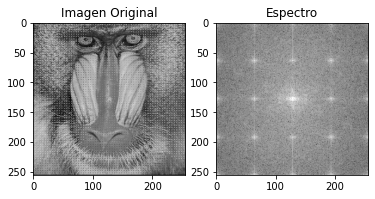

In [16]:
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20 * np.log(np.abs(fshift))
plt.subplot(121), plt.imshow(img, cmap='gray', vmax=255)
plt.title('Imagen Original')
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray', vmax=255)
plt.title('Espectro')
plt.show() 